<style>
    pre {
        white-space: pre-wrap;
        word-wrap: break-word;
    }
</style>

<div style="display:flex; justify-content:space-around; align-items:center; background-color:#cccccc; padding:5px; border:2px solid #333333;">
    <a href="https://estudios.upct.es/grado/5251/inicio" target="_blank">
    <img src="https://www.upct.es/contenido/universidad/galeria/identidad-2021/logos/logos-upct/marca-upct/marca-principal/horizontal/azul.png" alt="UPCT" style="height:145px; width:auto;">
    <a href="https://www.um.es/web/estudios/grados/ciencia-ingenieria-datos/" target="_blank">
    <img src="https://www.um.es/documents/1073494/42130150/LogosimboloUMU-positivo.png" alt="UMU" style="height:200px; width:auto;">
</div>

# Asignatura: **Deep Learning**

## Titulación: **Grado en Ciencia e Ingeniería de Datos**

## Práctica 1: Introducción al Deep Learning
### **Sesión 3/3: Redes neuronales preentrenadas**

**Autores**: Juan Morales Sánchez, Antonio Martínez Sánchez, José Luís Sancho Gómez y Juan Antonio Botía Blaya

___

### Objetivos

   - Familiarizarse con el *Transfer Learning*
   - Emplear redes neuronales preentrenadas en la práctica
   - Comparar distintos enfoques de reentrenamiento
   - Evaluar la eficacia y el coste computacional de las diferentes estrategias

### Contenidos
- [Aprendizaje por transferencia](#transferencia)
- [Red preentrenada como extractor de características](#extractor)
- [Ajuste fino de una red preentrenada (*Fine-Tuning*)](#fino)
- [Entrenamiento desde cero de un modelo profundo](#cero)
- [Ejercicios](#ejercicios)

### Bibliografía
- [Deep Learning with Python (segunda edición)](https://www.manning.com/books/deep-learning-with-python-second-edition)
- [Dive into Deep Learning](https://d2l.ai/)

### Requisitos
<a class='anchor' id='requisitos'></a>

Se trabajará con notebooks de [Jupyter](https://jupyter.org/install) con código Python empleando como intérprete la última versión de [Miniconda](https://docs.anaconda.com/miniconda/). Se requiere la preinstalación (se recomienda utilizar [pip](https://pypi.org/project/pip/)) de los siguientes paquetes de Python:

- [Numpy](https://pypi.org/project/numpy/) (computación numérica)
- [Scipy](https://pypi.org/project/scipy/) (computación científica)
- [Scikit-learn](https://pypi.org/project/scikit-learn/) (*Machine Learning*)
- [Scikit-image](https://pypi.org/project/scikit-image/) (*Image Processing*)
- [Matplotlib](https://pypi.org/project/matplotlib/) y [Seaborn](https://pypi.org/project/seaborn/) (visualización de datos)
- [Tensorflow](https://www.tensorflow.org/) 2.x que incluye a [Keras](https://www.tensorflow.org/guide/keras) 2.x (*Deep Learning*)

<div style="page-break-before: always;"></div>

<a class='anchor' id='transferencia'></a>

## Aprendizaje por transferencia

El aprendizaje por transferencia (*Transfer Learning*) es una técnica en el aprendizaje automático que reutiliza un modelo previamente entrenado en un conjunto de datos grande para resolver un problema relacionado pero diferente. Esta técnica es especialmente útil cuando no se dispone de suficientes datos o recursos para entrenar un modelo desde cero.

En el aprendizaje por transferencia, el conocimiento adquirido por un modelo al resolver una tarea (por ejemplo, clasificar imágenes en el conjunto ImageNet) se transfiere para abordar un nuevo problema. Esto se logra reutilizando las características aprendidas por las capas del modelo preentrenado y ajustando algunas partes (o todas) del modelo para adaptarse a la nueva tarea.

Utilizar una red preentrenada permite ahorrar tiempo y recursos computacionales al aprovechar el conocimiento previamente adquirido por estos modelos, que ya han sido entrenados en grandes conjuntos de datos (como ImageNet para visión por computador o modelos de lenguaje como GPT).

Existen 3 formas básicas de implementar el aprendizaje por transferencia para aprovechar una red preentrenada:

- Uso directo (sin modificaciones): La red preentrenada se usa "tal cual" para resolver tareas similares al conjunto de datos original sin necesidad de reentrenar. Se utiliza el modelo completo con su capa de salida original. Solo se hacen predicciones directamente con nuevos datos. Se trata de una situación poco habitual, que ocurre cuando el conjunto de datos de test es similar al conjunto de datos de entrenamiento del modelo original.

- Extracción de características: En este enfoque, la red preentrenada actúa como un extractor de características. Se utiliza la red preentrenada para procesar datos de entrada y obtener representaciones abstractas, que luego se utilizan como entrada para otro modelo más sencillo que concluye con la tarea objetivo.

- Ajuste fino (*Fine-Tuning*): Este enfoque consiste en reutilizar una red preentrenada y ajustar los pesos de algunas o todas las capas mediante un nuevo proceso de entrenamiento para sesgar el aprendizaje hacia nuestro conjunto de datos.

Veamos a continuación de forma práctica cómo aprovechar el *Transfer Learning* y los modelos preentrenados para mejorar la eficiencia del entrenamiento y la generalización del modelo. Para ello en primer lugar cargaremos el conjunto de datos [piedra-papel-tijeras](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors), que se utiliza para probar clasificadores:

In [1]:
# Importar librerías necesarias
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

tf.device('/GPU:0')

# Descargar el conjunto de entrenamiento del dataset rock-paper-scissors
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip"
dataset_path = get_file(origin=dataset_url, extract=True)
base_dir = os.path.join(os.path.dirname(dataset_path), 'rps.zip/rps')

# Preparar listas para imágenes y etiquetas
images = []
labels = []
class_names = ['rock', 'paper', 'scissors']

# Cargar las imágenes y etiquetas
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = load_img(img_path, target_size=(96, 96))   # Redimensionar imágenes
        # img_array = img_to_array(img) / 255.0            # Normalizar a [0, 1]
        img_array = img_to_array(img) / 127.5 - 1.0        # Normalizar a [-1, 1]
        images.append(img_array)
        labels.append(label)

# Convertir listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

x_train, y_train = images, labels

I0000 00:00:1770826326.320858  260875 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1770826326.348950  260875 cpu_feature_guard.cc:227] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1770826327.137848  260875 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0000 00:00:1770826327.917201  260875 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute c

In [2]:
# Importar librerías necesarias
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Descargar el conjunto de test del dataset rock-paper-scissors
dataset_url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
dataset_path = get_file(origin=dataset_url, extract=True)
base_dir = os.path.join(os.path.dirname(dataset_path), 'rps-test-set.zip/rps-test-set')

# Preparar listas para imágenes y etiquetas
images = []
labels = []
class_names = ['rock', 'paper', 'scissors']

# Cargar las imágenes y etiquetas
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = load_img(img_path, target_size=(96, 96))   # Redimensionar imágenes
        # img_array = img_to_array(img) / 255.0            # Normalizar a [0, 1]
        img_array = img_to_array(img) / 127.5 - 1.0        # Normalizar a [-1, 1]
        images.append(img_array)
        labels.append(label)

# Convertir listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

x_test, y_test = images, labels

<a class='anchor' id='extractor'></a>

## Red preentrenada como extractor de características

Este enfoque resulta útil cuando el **conjunto de datos disponible es pequeño o diferente** del conjunto de datos original de entrenamiento. Para aplicarlo se eliminan las capas finales del modelo (por ejemplo, la capa original de clasificación), y se conservan congeladas las capas restantes, generarán características representativas de los datos de entrada. Estas características alimentan la entrada de un nuevo clasificador/regresor final, cuyo entrenamiento se encarga de concluir la tarea.

En este ejemplo emplearemos la red [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) (versión minimalista), que ha sido preentenada con el conjunto de datos [ImageNet](https://image-net.org/download.php).

Habitualmente se emplean capas (de menor a mayor complejidad) ``GlobalAveragePooling2D``, ``Flatten`` o ``Dense`` como conexión entre ambos modelos, dependiendo de la cantidad de datos disponibles y de la complejidad del modelo deseado.

Observe que en este ejemplo de clasificación sobre un conjunto de datos sencillo como el [piedra-papel-tijeras](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) se alcanza fácilmente una buena clasificación.

/home/pyros05/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,243 (1.97 MB)

 Trainable params: 74,243 (290.01 KB)

 Non-trainable params: 441,000 (1.68 MB)

Epoch 1/5


I0000 00:00:1770826333.773024  260994 service.cc:153] XLA service 0x747f9404e200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770826333.773039  260994 service.cc:161]   StreamExecutor [0]: NVIDIA GeForce RTX 5060 Laptop GPU, Compute Capability 12.0a (Driver: 13.1.0; Runtime: 12.9.0; Toolkit: 12.5.0; DNN: 9.18.1)
I0000 00:00:1770826333.807200  260994 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770826334.120291  260994 cuda_dnn.cc:461] Loaded cuDNN version 91801
I0000 00:00:1770826334.128503  260994 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_5544__.82
I0000 00:00:1770826340.444276  260994 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7892 - loss: 0.6829

I0000 00:00:1770826341.732213  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_5544__.82


71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.9339 - loss: 0.2150 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0011
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 484ms/step - accuracy: 0.8414 - loss: 0.6261 
Precisión en datos de validación: 0.84
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8414 - loss: 0.6261     
Pérdida: 0.6260982751846313, Exactitud: 0.8413978219032288
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


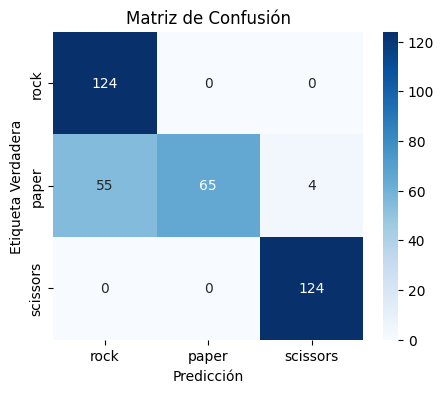

              precision    recall  f1-score   support

        rock       0.69      1.00      0.82       124
       paper       1.00      0.52      0.69       124
    scissors       0.97      1.00      0.98       124

    accuracy                           0.84       372
   macro avg       0.89      0.84      0.83       372
weighted avg       0.89      0.84      0.83       372



In [3]:
# Ejemplo de uso de red preentrenada como extractor de características para construir un clasificador

from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
tf.keras.utils.set_random_seed(2025)  # experimentos reproducibles: fija semilla para python base, numpy and tf

# Cargar el modelo preentrenado sin la capa superior
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3), include_preprocessing=False, minimalistic=True)

# Congelar las capas del modelo base
base_model.trainable = False

# Añadir capas superiores personalizadas
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # Capa densa personalizada
    Dense(3, activation='softmax')  # 3 clases: Rock, Paper, Scissors
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    # validation_data=(x_test, y_test),
    batch_size=32,
    epochs=5
)

# Evaluar el modelo en el conjunto de validación
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Precisión en datos de validación: {accuracy:.2f}")

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Pérdida: {loss}, Exactitud: {accuracy}")

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predicciones
y_pred = np.argmax(model.predict(x_test), axis=-1)
q =model.predict(x_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Reporte de métricas
print(classification_report(y_test, y_pred, target_names=class_names))

<a class='anchor' id='fino'></a>

## Ajuste fino de una red preentrenada (*Fine-Tuning*)

Se suele optar por esta configuración cuando el **conjunto de datos disponible es moderado o tiene similitudes con el conjunto original** de entrenamiento. En este caso las primeras capas (que aprendieron características genéricas como bordes o texturas) se mantienen congeladas (o con una tasa de aprendizaje muy baja). Las capas superiores (que aprenderán características específicas del nuevo conjunto de datos) se descongelan y se reentrenan con los nuevos datos.

Se puede usar de nuevo la red [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small), preentenada con el conjunto de datos [ImageNet](https://image-net.org/download.php), para implementar el ajuste fino. A pesar de la diferencia conceptual respecto al apartado anterior, la implementación es muy similar.

<a class='anchor' id='cero'></a>

## Entrenamiento desde cero de un modelo profundo

Para comparar las prestaciones, el coste computacional y el tiempo necesario para el entrenamiento, también es posible entrenar desde cero la red [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small), que en este caso se encontrará completamente desentrenada. En este caso el entrenamiento exige aproximadamente 200 épocas como mínimo.

<a class='anchor' id='ejercicios'></a>

## Ejercicios

**E1:** Partiendo del código proporcionado en el apartado previo referido al uso de redes preentrenadas como [extractores de características](#extractor), implemente el [ajuste fino de una red preentrenada](#fino), congelar las primeras 10 capas del modelo [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) preentrenado con [ImageNet](https://image-net.org/download.php), y permitiendo el reentrenamiento del resto de capas.

1. Cambie el número de capas descongeladas en un rango razonable,y analice su influencia en tiempo y prestaciones. 
2. Repita los experimentos con un modelo un poco más complejo (``minimalistic=False``), y analice su influencia en tiempo y prestaciones.
3. Añada [aumentación de datos](https://www.tensorflow.org/tutorials/images/data_augmentation) en las capas inferiores del modelo, al menos volteado horizontal y rotación aleatoria, y analice su influencia en tiempo y prestaciones.

**E2:** Modifique nuevamente el código de partida con el modelo [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) para evaluar el [entrenamiento desde cero de un modelo profundo](#cero).

1. Introduzca en los entrenamientos la [parada anticipada](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping), para aliviar el tiempo de cómputo necesario.
2. Elabore una tabla que compare cada una de las 3 soluciones (extractor de características, ajuste fino y entrenamiento desde cero), recogiendo el número de parámetros, número de épocas necesarias para el entrenamiento, tiempo de entrenamiento y las prestaciones generales en test.


<!---
**E4:** Partiendo del código proporcionado en el apartado previo referido al modelo [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) preentrenado con [ImageNet](https://image-net.org/download.php) como [extractores de características](#extractor), añada un análisis de validación cruzada [K-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), así como la [parada anticipada](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) durante el entrenamiento de cada uno de los K modelos, para evitar el sobreentrenamiento. Realice experimentos con K = 5, y compare los resultados entre *folds*.
-->


/home/pyros05/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Total capas base_model: 102
Capas congeladas: 10
Capas entrenables: 92


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,243 (1.97 MB)

 Trainable params: 502,203 (1.92 MB)

 Non-trainable params: 13,040 (50.94 KB)

Epoch 1/10


I0000 00:00:1770826369.686939  260993 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_31991__.206


68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6714 - loss: 0.7704

I0000 00:00:1770826382.972881  260991 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_31991__.206


71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.8607 - loss: 0.4081 - val_accuracy: 0.7540 - val_loss: 0.5802
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 0.0345 - val_accuracy: 0.9325 - val_loss: 0.2401
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.9881 - val_loss: 0.1329
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9881 - val_loss: 0.0854
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9921 - val_loss: 0.0575
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9960 - val_loss: 0.0394
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0264
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0176


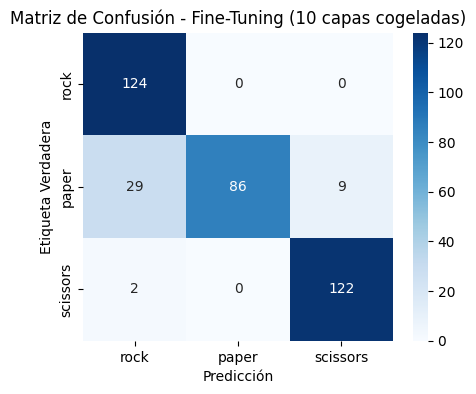

              precision    recall  f1-score   support

        rock       0.80      1.00      0.89       124
       paper       1.00      0.69      0.82       124
    scissors       0.93      0.98      0.96       124

    accuracy                           0.89       372
   macro avg       0.91      0.89      0.89       372
weighted avg       0.91      0.89      0.89       372



In [4]:
# Ejercicio 1: Ajuste fino (Fine-Tuning) - Capas congeladas: 10 primeras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
import time

tf.keras.utils.set_random_seed(2025)

# Cargar el modelo preentrenado
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(96, 96, 3),
                              include_preprocessing=False, minimalistic=True)

# Descongelar todas las capas primero
base_model.trainable = True

# Congelar las primeras 10 capas
for layer in base_model.layers[:10]:
    layer.trainable = False

print(f"Total capas base_model: {len(base_model.layers)}")
print(f"Capas congeladas: {sum(not l.trainable for l in base_model.layers)}")
print(f"Capas entrenables: {sum(l.trainable for l in base_model.layers)}")

model_ft = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(3, activation="softmax")
])

# Usar learning rate bajo para fine-tunning
model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_ft.summary()

start_time = time.time()
history_ft = model_ft.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=10
)
ft_time = time.time() - start_time

loss_ft, accuracy_ft = model.evaluate(x_test, y_test)
print(f"\nFine-Tuning (10 capas cogeladas) - Pérdida: {loss_ft:.4f}, Exactitud: {accuracy_ft:.4f}")
print(f"Tiempo de entrenamiento: {ft_time:.2f}s")

y_pred_ft = np.argmax(model_ft.predict(x_test), axis=-1)
cm = confusion_matrix(y_test, y_pred_ft)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - Fine-Tuning (10 capas cogeladas)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()
print(classification_report(y_test, y_pred_ft, target_names=class_names))



/home/pyros05/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1770826413.658796  260993 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_61671__.218
I0000 00:00:1770826422.919391  260993 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_61671__.218


Capas congeladas:   0 | Acc test: 0.9086 | Loss: 0.2876 | Tiempo: 32.0s | Params entrenables: 503131


I0000 00:00:1770826448.102662  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_88610__.214
I0000 00:00:1770826456.104345  260991 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_88610__.214


Capas congeladas:   5 | Acc test: 0.8925 | Loss: 0.3166 | Tiempo: 29.5s | Params entrenables: 502667


I0000 00:00:1770826480.158049  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_114589__.206
I0000 00:00:1770826488.263406  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_114589__.206


Capas congeladas:  10 | Acc test: 0.8925 | Loss: 0.3146 | Tiempo: 29.7s | Params entrenables: 502203


I0000 00:00:1770826511.675347  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_138976__.194
I0000 00:00:1770826518.905078  260993 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_138976__.194


Capas congeladas:  20 | Acc test: 0.9220 | Loss: 0.2323 | Tiempo: 27.5s | Params entrenables: 496227


I0000 00:00:1770826540.646110  260990 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_161533__.178
I0000 00:00:1770826546.745258  260991 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_161533__.178


Capas congeladas:  30 | Acc test: 0.8360 | Loss: 0.3380 | Tiempo: 23.9s | Params entrenables: 490427


I0000 00:00:1770826567.194382  260991 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_182608__.166
I0000 00:00:1770826572.992210  260990 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_182608__.166


Capas congeladas:  40 | Acc test: 0.8898 | Loss: 0.2456 | Tiempo: 23.4s | Params entrenables: 475371


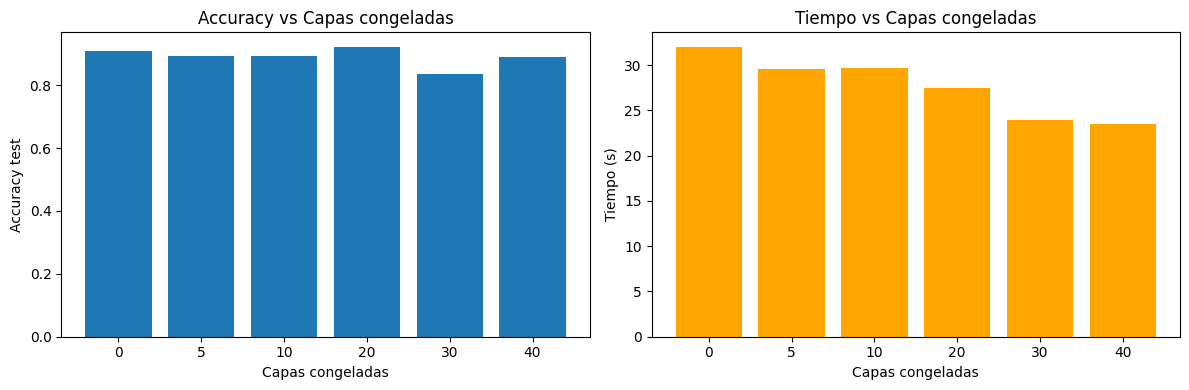

In [5]:
# Apartado 1: Variación del número de capas congeladas

import time
import tensorflow as tf

results_frozen = []

for n_frozen in [0, 5, 10, 20, 30, 40]:
    tf.keras.utils.set_random_seed(2025)

    base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(96, 96, 3),
                                  include_preprocessing=False, minimalistic=True)
    base_model.trainable = True
    for layer in base_model.layers[:n_frozen]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    trainable_params = model.count_params() - sum(
        tf.keras.backend.count_params(w) for l in model.layers for w in l.non_trainable_weights
    )

    start = time.time()
    history = model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10, verbose=0)
    elapsed = time.time() - start

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results_frozen.append({
        "capas_congeladas": n_frozen,
        "params_entrenables": trainable_params,
        "accuracy_test": acc,
        "loss_test": loss,
        "tiempo_s": elapsed,
        "epochs": 10
    })
    print(f"Capas congeladas: {n_frozen:3d} | Acc test: {acc:.4f} | Loss: {loss:.4f} | Tiempo: {elapsed:.1f}s | Params entrenables: {trainable_params}")

# Gráfica comparativa
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
capas = [r['capas_congeladas'] for r in results_frozen]
axes[0].bar(range(len(capas)), [r['accuracy_test'] for r in results_frozen], tick_label=capas)
axes[0].set_xlabel('Capas congeladas')
axes[0].set_ylabel('Accuracy test')
axes[0].set_title('Accuracy vs Capas congeladas')
axes[1].bar(range(len(capas)), [r['tiempo_s'] for r in results_frozen], tick_label=capas, color='orange')
axes[1].set_xlabel('Capas congeladas')
axes[1].set_ylabel('Tiempo (s)')
axes[1].set_title('Tiempo vs Capas congeladas')
plt.tight_layout()
plt.show()



In [6]:
# Apartado 2: Modelo más complejo (minimalistic=False)

results_frozen = []

for n_frozen in [0, 10, 20, 40]:
    tf.keras.utils.set_random_seed(2025)

    base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(96, 96, 3),
                                  include_preprocessing=False, minimalistic=False)
    base_model.trainable = True
    for layer in base_model.layers[:n_frozen]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    trainable_params = model.count_params() - sum(
        tf.keras.backend.count_params(w) for l in model.layers for w in l.non_trainable_weights
    )

    start = time.time()
    history = model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10, verbose=0)
    elapsed = time.time() - start

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results_frozen.append({
        "capas_congeladas": n_frozen,
        "params_entrenables": trainable_params,
        "accuracy_test": acc,
        "loss_test": loss,
        "tiempo_s": elapsed,
        "epochs": 10
    })
    print(f"[Complex] Capas congeladas: {n_frozen:3d} | Acc test: {acc:.4f} | Loss: {loss:.4f} | Tiempo: {elapsed:.1f}s")

print(f"\nTotal capas modelo complejo: {len(base_model.layers)}")

/home/pyros05/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1770826596.460725  260989 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_217039__.281
I0000 00:00:1770826614.907720  260990 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_217039__.281


[Complex] Capas congeladas:   0 | Acc test: 0.8817 | Loss: 0.2905 | Tiempo: 55.0s


I0000 00:00:1770826657.760802  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_251055__.273
I0000 00:00:1770826668.444301  260989 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_251055__.273


[Complex] Capas congeladas:  10 | Acc test: 0.7715 | Loss: 0.5086 | Tiempo: 39.0s


I0000 00:00:1770826699.170460  260992 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_283839__.265
I0000 00:00:1770826709.188162  260994 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_283839__.265


[Complex] Capas congeladas:  20 | Acc test: 0.8441 | Loss: 0.3799 | Tiempo: 36.8s


I0000 00:00:1770826739.067209  260989 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_313233__.237
I0000 00:00:1770826747.882017  260990 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_313233__.237


[Complex] Capas congeladas:  40 | Acc test: 0.9274 | Loss: 0.2012 | Tiempo: 34.4s

Total capas modelo complejo: 156


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,243 (1.97 MB)

 Trainable params: 502,203 (1.92 MB)

 Non-trainable params: 13,040 (50.94 KB)

Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.7434 - loss: 0.6370 - val_accuracy: 0.9921 - val_loss: 0.0562
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9674 - loss: 0.1318 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9846 - loss: 0.0649 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9912 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9960 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9947 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9978 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9978 - loss: 0.0129 - val_accuracy: 1.0000 - 

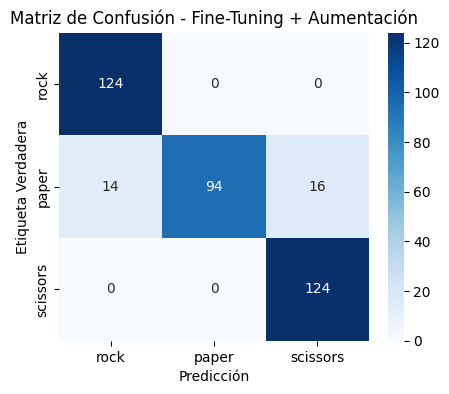

              precision    recall  f1-score   support

        rock       0.90      1.00      0.95       124
       paper       1.00      0.76      0.86       124
    scissors       0.89      1.00      0.94       124

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372



In [7]:
# Apartado 3: Fine-Tuning con aumentación de datos

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Model, Input

tf.keras.utils.set_random_seed(2025)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3),
                               include_preprocessing=False, minimalistic=True)
base_model.trainable = True
for layer in base_model.layers[:10]:
    layer.trainable = False

# Modelo con aumentación de datos
inputs = Input(shape=(96, 96, 3))
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.15)(x)
x = RandomZoom(0.1)(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model_aug = Model(inputs, outputs)
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_aug.summary()

start = time.time()
history_aug = model_aug.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=15
)
aug_time = time.time() - start

loss_aug, acc_aug = model_aug.evaluate(x_test, y_test)
print(f"\nFine-Tuning + Aumentación - Pérdida: {loss_aug:.4f}, Exactitud: {acc_aug:.4f}")
print(f"Tiempo de entrenamiento: {aug_time:.2f}s")

y_pred_aug = np.argmax(model_aug.predict(x_test), axis=-1)
cm = confusion_matrix(y_test, y_pred_aug)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Fine-Tuning + Aumentación')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()
print(classification_report(y_test, y_pred_aug, target_names=class_names))



/home/pyros05/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,243 (1.97 MB)

 Trainable params: 503,131 (1.92 MB)

 Non-trainable params: 12,112 (47.31 KB)

Epoch 1/200


I0000 00:00:1770826838.970456  260978 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_370970__.218


67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8721 - loss: 0.3278

I0000 00:00:1770826847.409693  260978 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_370970__.218


71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.9643 - loss: 0.0943 - val_accuracy: 1.0000 - val_loss: 4.3601e-05
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1019e-04 - val_accuracy: 1.0000 - val_loss: 7.3894e-05
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3735e-05 - val_accuracy: 1.0000 - val_loss: 8.1474e-05
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.6891e-05 - val_accuracy: 1.0000 - val_loss: 1.0471e-04
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7638e-05 - val_accuracy: 1.0000 - val_loss: 9.4392e-05
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2057e-05 - val_accuracy: 1.0000 - val_loss: 6.0694e-05
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss

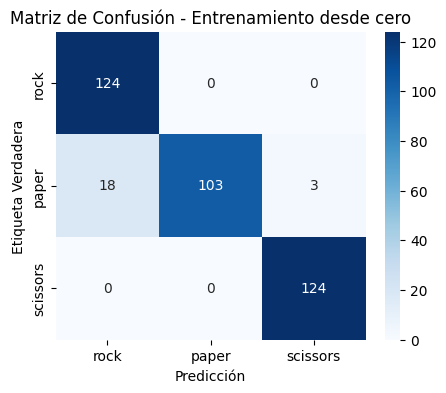

              precision    recall  f1-score   support

        rock       0.87      1.00      0.93       124
       paper       1.00      0.83      0.91       124
    scissors       0.98      1.00      0.99       124

    accuracy                           0.94       372
   macro avg       0.95      0.94      0.94       372
weighted avg       0.95      0.94      0.94       372



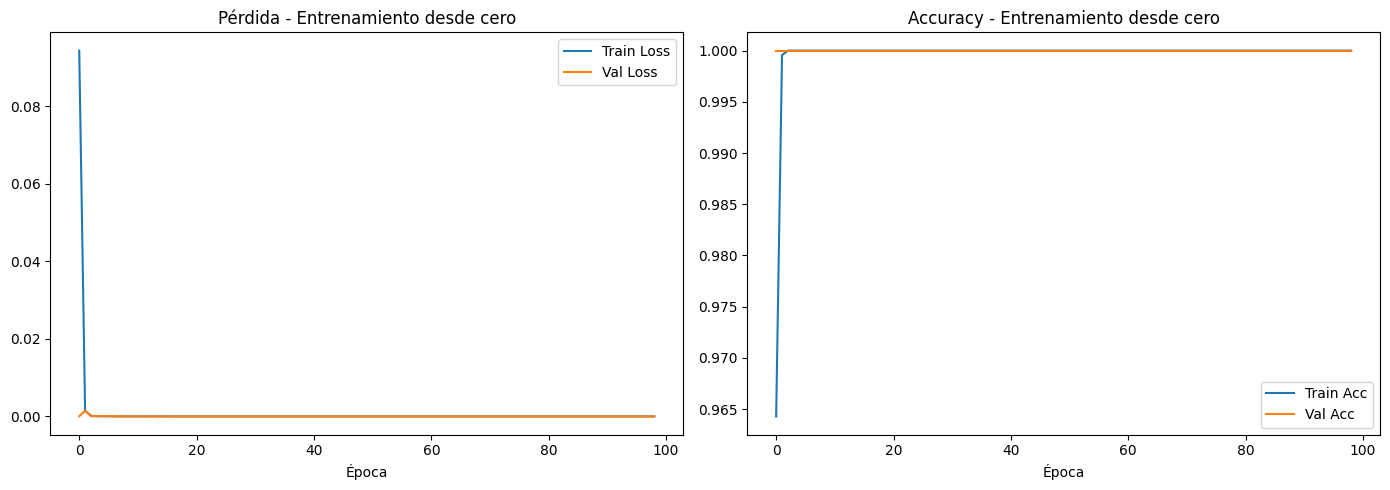

In [8]:
# Ejercicio 2
# Apartado 1: Entrenamiento desde cero con EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(2025)

# Modelo desde cero (weights=None)
base_model_scratch = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3),
                               include_preprocessing=False, minimalistic=True)
base_model_scratch.trainable = True

model_scratch = Sequential([
    base_model_scratch,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(3, activation="softmax")
])

model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_scratch.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

start = time.time()
history_scratch = model_scratch.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=200,
    callbacks=[early_stop]
)
scratch_time = time.time() - start
scratch_epochs = len(history_scratch.history['loss'])

loss_scratch, acc_scratch = model_scratch.evaluate(x_test, y_test)
print(f"\nDesde cero - Pérdida: {loss_scratch:.4f}, Exactitud: {acc_scratch:.4f}")
print(f"Épocas: {scratch_epochs}, Tiempo: {scratch_time:.2f}s")

y_pred_scratch = np.argmax(model_scratch.predict(x_test), axis=-1)
cm = confusion_matrix(y_test, y_pred_scratch)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Entrenamiento desde cero')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()
print(classification_report(y_test, y_pred_scratch, target_names=class_names))

# Curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history_scratch.history['loss'], label='Train Loss')
axes[0].plot(history_scratch.history['val_loss'], label='Val Loss')
axes[0].set_title('Pérdida - Entrenamiento desde cero')
axes[0].set_xlabel('Época')
axes[0].legend()
axes[1].plot(history_scratch.history['accuracy'], label='Train Acc')
axes[1].plot(history_scratch.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Accuracy - Entrenamiento desde cero')
axes[1].set_xlabel('Época')
axes[1].legend()
plt.tight_layout()
plt.show()

In [10]:
# Apartado 2: EarlyStopping también con extractor y fine-tunning para comparación justa

# --- Extractor de características con EarlyStopping ---
tf.keras.utils.set_random_seed(2025)
base_ext = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3),
                             include_preprocessing=False, minimalistic=True)
base_ext.trainable = False

model_ext = Sequential([
    base_ext, GlobalAveragePooling2D(),
    Dense(128, activation='relu'), Dense(3, activation='softmax')
])
model_ext.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop_ext = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
start = time.time()
hist_ext = model_ext.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=50,
                         callbacks=[early_stop_ext], verbose=0)
ext_time = time.time() - start
ext_epochs = len(hist_ext.history['loss'])
loss_ext, acc_ext = model_ext.evaluate(x_test, y_test, verbose=0)
ext_trainable = sum(tf.keras.backend.count_params(w) for l in model_ext.layers for w in l.trainable_weights)

# --- Fine-Tuning con EarlyStopping ---
tf.keras.utils.set_random_seed(2025)
base_ft2 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3),
                              include_preprocessing=False, minimalistic=True)
base_ft2.trainable = True
for layer in base_ft2.layers[:10]:
    layer.trainable = False

model_ft2 = Sequential([
    base_ft2, GlobalAveragePooling2D(),
    Dense(128, activation='relu'), Dense(3, activation='softmax')
])
model_ft2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop_ft = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
start = time.time()
hist_ft2 = model_ft2.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=50,
                          callbacks=[early_stop_ft], verbose=0)
ft2_time = time.time() - start
ft2_epochs = len(hist_ft2.history['loss'])
loss_ft2, acc_ft2 = model_ft2.evaluate(x_test, y_test, verbose=0)
ft2_trainable = sum(tf.keras.backend.count_params(w) for l in model_ft2.layers for w in l.trainable_weights)

# --- Desde cero (usar resultados anteriores) ---
scratch_trainable = sum(tf.keras.backend.count_params(w) for l in model_scratch.layers for w in l.trainable_weights)

print("=" * 100)
print(f"{'Método':<30} {'Params entrenables':>18} {'Épocas':>8} {'Tiempo (s)':>12} {'Acc test':>10} {'Loss test':>10}")
print("=" * 100)
print(f"{'Extractor de características':<30} {ext_trainable:>18,} {ext_epochs:>8} {ext_time:>12.1f} {acc_ext:>10.4f} {loss_ext:>10.4f}")
print(f"{'Fine-Tuning (10 congeladas)':<30} {ft2_trainable:>18,} {ft2_epochs:>8} {ft2_time:>12.1f} {acc_ft2:>10.4f} {loss_ft2:>10.4f}")
print(f"{'Entrenamiento desde cero':<30} {scratch_trainable:>18,} {scratch_epochs:>8} {scratch_time:>12.1f} {acc_scratch:>10.4f} {loss_scratch:>10.4f}")
print("=" * 100)

I0000 00:00:1770827100.026046  260976 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_530692__.82
I0000 00:00:1770827102.489692  260981 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_530692__.82


Restoring model weights from the end of the best epoch: 50.


I0000 00:00:1770827131.744258  260989 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_587944__.206
I0000 00:00:1770827139.592001  260976 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_587944__.206


Restoring model weights from the end of the best epoch: 50.
Método                         Params entrenables   Épocas   Tiempo (s)   Acc test  Loss test
Extractor de características               74,243       50         24.9     0.8199     0.7884
Fine-Tuning (10 congeladas)               502,203       50         48.7     0.9301     0.2125
Entrenamiento desde cero                  503,131       99         78.2     0.9435     0.2006
